In [2]:
import torch
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_images = np.load('/content/drive/MyDrive/Colab Notebooks/mnist_train_colored.npy')

In [6]:
train_images = torch.tensor(train_images).permute(0,3,1,2).float()/255.0

In [7]:
from torch.utils.data import TensorDataset,DataLoader

In [8]:
test_images = np.load('/content/drive/MyDrive/Colab Notebooks/mnist_test_colored.npy')
test_imagesInverted = np.load('/content/drive/MyDrive/Colab Notebooks/mnist_test_colored-inverted.npy')

In [9]:
test_labels = np.load('/content/drive/MyDrive/Colab Notebooks/mnist_testLabels_colored.npy')

In [10]:
test_images = torch.tensor(test_images).permute(0,3,1,2).float()/255.0
test_imagesInverted = torch.tensor(test_imagesInverted).permute(0,3,1,2).float()/255.0

In [11]:
test_labels = torch.tensor(test_labels).long()

In [12]:
TestDataset = TensorDataset(test_images,test_labels)
TestDatasetInverted = TensorDataset(test_imagesInverted,test_labels)

In [13]:
Test_Batch = DataLoader(TestDataset,batch_size=64,shuffle=True)
Test_BatchInverted = DataLoader(TestDatasetInverted,batch_size=64,shuffle=True)

In [14]:
train_labels = np.load('/content/drive/MyDrive/Colab Notebooks/mnist_trainLabels_colored.npy')

In [15]:
train_labels = torch.tensor(train_labels).long()

In [16]:
train_images[0].shape

torch.Size([3, 28, 28])

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Layer 1: 3 input channels (RGB), 16 filters, 3x3 kernel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Layer 2: 16 input channels, 32 filters, 3x3 kernel
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Max pooling to shrink the image size
        self.pool = nn.MaxPool2d(2, 2)

        # After two 2x2 pools, a 28x28 image becomes 7x7
        # 32 filters * 7 * 7 = 1568 features
        self.fc = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 28x28 -> 14x14
        x = self.pool(F.relu(self.conv2(x))) # 14x14 -> 7x7
        x = torch.flatten(x, 1)              # Flatten to 1D
        x = self.fc(x)                       # Final 10 scores
        return x


In [40]:
model_cnn77 = SimpleCNN().to(device)
model_cnn77.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CNNmodelSaved77TestAccuracy!.pth',map_location=device))
# model_cnn.eval()

<All keys matched successfully>

In [41]:
model_cnn94 = SimpleCNN().to(device)
model_cnn94.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/CNNmodelSaved94Method-2(MSE)TestAccuracy!.pth',map_location=device))
# model_cnn.eval()

<All keys matched successfully>

In [42]:
model_cnnLazy = SimpleCNN().to(device)
model_cnnLazy.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/3-simpleCNNmodelSaved.pth',map_location=device))
# model_cnn.eval()

<All keys matched successfully>

In [43]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    model.eval() # Vital: Disables BatchNorm/Dropout changes

In [44]:
freeze_model(model_cnn77)
freeze_model(model_cnn94)
freeze_model(model_cnnLazy)

In [20]:
# 1. Switch to evaluation mode
model_cnnLazy.eval()

correct = 0
total = 0

# 2. No gradients needed for testing
with torch.no_grad():
    for Invertedimages, Invertedlabels in Test_BatchInverted:
        Invertedimages, Invertedlabels = Invertedimages.to(device), Invertedlabels.to(device)

        # Forward pass
        outputsInvertedCNN = model_cnnLazy(Invertedimages)

        # Get predictions
        _, predictedInvert = torch.max(outputsInvertedCNN, 1)
        # flatPred = predictedInvert.flatten()
        # flatLabel = Invertedlabels.flatten()
        # if all_predBGCNNInverted.device != device:
        #     all_predBGCNNInverted = all_predBGCNNInverted.to(device)
        # if all_labelsBGCNNInverted.device != device:
        #     all_labelsBGCNNInverted = all_labelsBGCNNInverted.to(device)
        # all_predBGCNNInverted = torch.cat((all_predBGCNNInverted, flatPred))
        # all_labelsBGCNNInverted = torch.cat((all_labelsBGCNNInverted, flatLabel))
        # Update totals
        total += Invertedlabels.size(0)
        correct += (predictedInvert == Invertedlabels).sum().item()

accuracy_simple = 100 * correct / total
print(f'Simple  CNN testing Inverted Accuracy: {accuracy_simple:.2f}%')

Simple  CNN testing Inverted Accuracy: 23.02%


In [21]:
# 1. Switch to evaluation mode
model_cnn77.eval()

correct = 0
total = 0

# 2. No gradients needed for testing
with torch.no_grad():
    for Invertedimages, Invertedlabels in Test_BatchInverted:
        Invertedimages, Invertedlabels = Invertedimages.to(device), Invertedlabels.to(device)

        # Forward pass
        outputsInvertedCNN = model_cnn77(Invertedimages)

        # Get predictions
        _, predictedInvert = torch.max(outputsInvertedCNN, 1)
        # flatPred = predictedInvert.flatten()
        # flatLabel = Invertedlabels.flatten()
        # if all_predBGCNNInverted.device != device:
        #     all_predBGCNNInverted = all_predBGCNNInverted.to(device)
        # if all_labelsBGCNNInverted.device != device:
        #     all_labelsBGCNNInverted = all_labelsBGCNNInverted.to(device)
        # all_predBGCNNInverted = torch.cat((all_predBGCNNInverted, flatPred))
        # all_labelsBGCNNInverted = torch.cat((all_labelsBGCNNInverted, flatLabel))
        # Update totals
        total += Invertedlabels.size(0)
        correct += (predictedInvert == Invertedlabels).sum().item()

accuracy_simple = 100 * correct / total
print(f'Simple  CNN testing Inverted Accuracy: {accuracy_simple:.2f}%')

Simple  CNN testing Inverted Accuracy: 77.69%


In [22]:
# 1. Switch to evaluation mode
model_cnn94.eval()

correct = 0
total = 0

# 2. No gradients needed for testing
with torch.no_grad():
    for Invertedimages, Invertedlabels in Test_BatchInverted:
        Invertedimages, Invertedlabels = Invertedimages.to(device), Invertedlabels.to(device)

        # Forward pass
        outputsInvertedCNN = model_cnn94(Invertedimages)

        # Get predictions
        _, predictedInvert = torch.max(outputsInvertedCNN, 1)
        # flatPred = predictedInvert.flatten()
        # flatLabel = Invertedlabels.flatten()
        # if all_predBGCNNInverted.device != device:
        #     all_predBGCNNInverted = all_predBGCNNInverted.to(device)
        # if all_labelsBGCNNInverted.device != device:
        #     all_labelsBGCNNInverted = all_labelsBGCNNInverted.to(device)
        # all_predBGCNNInverted = torch.cat((all_predBGCNNInverted, flatPred))
        # all_labelsBGCNNInverted = torch.cat((all_labelsBGCNNInverted, flatLabel))
        # Update totals
        total += Invertedlabels.size(0)
        correct += (predictedInvert == Invertedlabels).sum().item()

accuracy_simple = 100 * correct / total
print(f'Simple  CNN testing Inverted Accuracy: {accuracy_simple:.2f}%')

Simple  CNN testing Inverted Accuracy: 94.18%


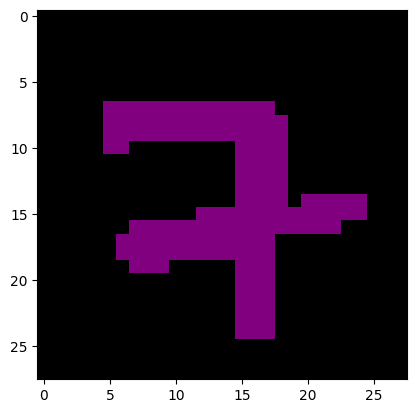

In [45]:
import matplotlib.pyplot as plt
indices_arr = np.where(train_labels==7)[0]
img = train_images[indices_arr[2]].permute(1,2,0).numpy()
plt.imshow(img)

In [46]:
img.shape

(28, 28, 3)

In [47]:
real_img = train_images[indices_arr[2]].unsqueeze(0)

In [48]:
real_img.shape

torch.Size([1, 3, 28, 28])

In [49]:
real_img.shape

torch.Size([1, 3, 28, 28])

In [50]:
probablities = torch.zeros(1,10)
probablities.shape

torch.Size([1, 10])

In [59]:
alpha = 0.001
target_label = torch.tensor([3]).to(device)
probablities = torch.zeros(1, 10).to(device)
real_img = real_img.to(device)
InvisibleNoise = (torch.randn_like(real_img)*0.001).to(device).requires_grad_(True)
while probablities[0][3].item() < 0.9:
    logitsScoreZ = model_cnnLazy(real_img + InvisibleNoise)
    probablities = torch.softmax(logitsScoreZ, dim=1)
    loss = F.cross_entropy(logitsScoreZ, target_label)
    # print(loss)
    if InvisibleNoise.grad is not None:
        InvisibleNoise.grad.zero_()
    loss.backward()
    with torch.no_grad():
        InvisibleNoise.data.sub_(alpha * InvisibleNoise.grad.sign())
eRequired = InvisibleNoise.abs().max()
print(f"eRequired:{eRequired}")
final_logits = model_cnnLazy(real_img + InvisibleNoise)
final_pred = torch.argmax(final_logits).item()
current_conf = probablities[0][3].item()
print(f"ConfidenceIn3: {current_conf}, Final Model Prediction: {final_pred}")

eRequired:0.09531045705080032
ConfidenceIn3: 0.9094539880752563, Final Model Prediction: 3


In [60]:
alpha = 0.001
target_label = torch.tensor([3]).to(device)
probablities = torch.zeros(1, 10).to(device)
real_img = real_img.to(device)
InvisibleNoise = (torch.randn_like(real_img)*0.001).to(device).requires_grad_(True)
InvisibleNoise.data.clamp_(-0.05, 0.05)
while probablities[0][3].item() < 0.9:
    logitsScoreZ = model_cnn94(real_img + InvisibleNoise)
    probablities = torch.softmax(logitsScoreZ, dim=1)
    loss = F.cross_entropy(logitsScoreZ, target_label)
    # print(loss)
    if InvisibleNoise.grad is not None:
        InvisibleNoise.grad.zero_()
    loss.backward()
    with torch.no_grad():
        InvisibleNoise.data.sub_(alpha * InvisibleNoise.grad.sign())
        InvisibleNoise.data.clamp_(-0.05, 0.05)
eRequired = InvisibleNoise.abs().max()
print(f"eRequired:{eRequired}")
final_logits = model_cnn94(real_img + InvisibleNoise)
final_pred = torch.argmax(final_logits).item()
current_conf = probablities[0][3].item()
print(f"ConfidenceIn3: {current_conf}, Final Model Prediction: {final_pred}")

KeyboardInterrupt: 

In [61]:
alpha = 0.01
target_label = torch.tensor([3]).to(device)
probablities = torch.zeros(1, 10).to(device)
real_img = real_img.to(device)
InvisibleNoise = (torch.randn_like(real_img)*0.001).to(device).requires_grad_(True)
InvisibleNoise.data.clamp_(-0.05, 0.05)
while probablities[0][3].item() < 0.9:
    logitsScoreZ = model_cnnLazy(real_img + InvisibleNoise)
    probablities = torch.softmax(logitsScoreZ, dim=1)
    loss = F.cross_entropy(logitsScoreZ, target_label)
    # print(loss)
    if InvisibleNoise.grad is not None:
        InvisibleNoise.grad.zero_()
    loss.backward()
    with torch.no_grad():
        InvisibleNoise.data.sub_(alpha * InvisibleNoise.grad.sign())
        InvisibleNoise.data.clamp_(-0.05, 0.05)
eRequired = InvisibleNoise.abs().max()
print(f"eRequired:{eRequired}")
final_logits = model_cnnLazy(real_img + InvisibleNoise)
final_pred = torch.argmax(final_logits).item()
current_conf = probablities[0][3].item()
print(f"ConfidenceIn3: {current_conf}, Final Model Prediction: {final_pred}")

KeyboardInterrupt: 

In [53]:
alpha = 0.001
target_label = torch.tensor([3]).to(device)
probablities = torch.zeros(1, 10).to(device)
real_img = real_img.to(device)
InvisibleNoise = (torch.randn_like(real_img)*0.001).to(device).requires_grad_(True)
for i in range(1000):
    logitsScoreZ = model_cnnLazy(real_img + InvisibleNoise)
    probablities = torch.softmax(logitsScoreZ, dim=1)
    current_conf = probablities[0][3].item()
    # print(current_conf)
    if current_conf > 0.90:
        print(f"Confidence in '3': {current_conf:.2%}")
        break
    loss = F.cross_entropy(logitsScoreZ, target_label)
    # print(loss)
    if InvisibleNoise.grad is not None:
        InvisibleNoise.grad.zero_()
    loss.backward()
    with torch.no_grad():
        InvisibleNoise.data.sub_(alpha * InvisibleNoise.grad.sign())
        InvisibleNoise.data.clamp_(-0.15, 0.15)
        temp_img = torch.clamp(real_img + InvisibleNoise, 0, 1)
        InvisibleNoise.copy_(temp_img - real_img)
final_logits = model_cnnLazy(real_img + InvisibleNoise)
final_pred = torch.argmax(final_logits).item()
print(f"ConfidenceIn3: {current_conf}, stepsTookBYLazyModel: {i}, Final Model Prediction: {final_pred}")

Confidence in '3': 90.05%
ConfidenceIn3: 0.9004572033882141, stepsTookBYLazyModel: 142, Final Model Prediction: 3


In [67]:
alpha = 0.02
target_label = torch.tensor([3]).to(device)
probablities = torch.zeros(1, 10).to(device)
real_img = real_img.to(device) # Ensure real_img is on the device
InvisibleNoise = (torch.randn_like(real_img)*0.001).to(device).requires_grad_(True)
InvisibleNoise.data.clamp_(-0.05, 0.05)
for i in range(1000):
    logits = model_cnn94(real_img + InvisibleNoise)
    probablities = torch.softmax(logits, dim=1)
    current_conf = probablities[0][3].item()

    if current_conf > 0.90:
        print(f"Confidence in '3': {current_conf:.2%}")
        break

    # The previous two loss definitions were problematic. We will use F.cross_entropy.
    loss = F.cross_entropy(logits, target_label)

    if InvisibleNoise.grad is not None:
        InvisibleNoise.grad.zero_()
    loss.backward()
    with torch.no_grad():
        InvisibleNoise.data.sub_(alpha * InvisibleNoise.grad.sign())
        InvisibleNoise.data.clamp_(-0.05, 0.05)
        temp_img = torch.clamp(real_img + InvisibleNoise, 0, 1)
        InvisibleNoise.copy_(temp_img - real_img)

final_logits = model_cnn94(real_img + InvisibleNoise)
final_pred = torch.argmax(final_logits).item()
current_conf = probablities[0][3].item() # Update current_conf one last time for final print
print(f"ConfidenceIn3: {current_conf}, stepsTookBYRobust94Model: {i}, Final Model Prediction: {final_pred}")
print(final_logits)

ConfidenceIn3: 0.20980791747570038, stepsTookBYRobust94Model: 999, Final Model Prediction: 7
tensor([[-6.8266, -3.6003,  3.8883,  3.7773, -4.5587, -2.8659, -6.3944,  4.7393,
         -7.8742,  0.6859]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [68]:
# 1. Navigate to your project folder
%cd /content/drive/MyDrive/Colab Notebooks

# 2. Initialize git and link to your repo
!git init
!git config --global user.email "masthansharif.shaik@students.iiit.ac.in"
!git config --global user.name "sharif_commits"
!git remote add origin https://github.com/sharif_commits/Precog-Task-CV.git

# 3. Add and Push
!git add .
!git commit -m "Moving folder from Google Drive"
!git push -u origin main

/content/drive/.shortcut-targets-by-id/1HOtNboNsGX82TtcpzyEq86UadqJpJ_8z/Colab Notebooks
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/drive/.shortcut-targets-by-id/1HOtNboNsGX82TtcpzyEq86UadqJpJ_8z/Colab Notebooks/.git/
[master (root-commit) b3eb290] Moving folder from Google Drive
 32 files changed, 7 insertions(+)
 create mode 100644 3-simpleCNNmodelSaved.pth
 create mode 100644 CNNBGmodelSaved.pth
 create mode 100644 CNNBGmodelSaved30Accuracy.pth
 create mode 100644 CNNBGmodelSaved35OnOldAccuracy.pth
 creat